## Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset,concatenate_datasets
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Loading The Data

In [2]:
dataset = load_dataset('sst', trust_remote_code=True)

### Preprocessing

In [3]:
def map_class(value):
    return np.digitize(value, bins=[0.2, 0.4, 0.6, 0.8], right=False)

In [4]:
dataset_mapped = dataset.map(lambda example: {'label': map_class(example['label'])})

In [5]:
# Access the training set
train_data = concatenate_datasets([dataset_mapped['train'], dataset_mapped['validation']])
train_labels = np.array(train_data['label'],dtype=np.int8)

# Access the test set
test_data = dataset_mapped['test']
test_labels = np.array(test_data['label'],dtype=np.int8)

num_classes = 5

pd.Series(test_labels).value_counts()

1    633
3    510
4    399
2    389
0    279
Name: count, dtype: int64

### Part 1: Naïve Bayes 

#### Algorithm Implementation

In [6]:
def train_naive_bayes(D,num_classes):
     
    n_doc = len(D) 
    cls_prior = np.zeros(num_classes)
    vocab = set()  # To store the vocabulary
    cls_word_cnt = np.array([{} for _ in range(num_classes)]) 

    for example in D:
        example_class = int(example["label"])  # Get the class label for the example
        cls_prior[example_class] += 1  # Count the number of documents for each class
        for word in example["tokens"].split("|"):  
            # Update word count for the corresponding class
            cls_word_cnt[example_class][word] = cls_word_cnt[example_class].get(word, 0) + 1
            vocab.add(word)  # Add word to the vocabulary
           
    cls_prior /= n_doc  # Calculate prior probabilities
    log_prior = np.log(cls_prior)  # Convert prior probabilities to log space
    
    vocab_size = len(vocab)
    cls_total_word_cnt = np.array([sum(cls_dict.values()) for cls_dict in cls_word_cnt])  # Total word count for each class
    
    # Calculate log likelihood with smoothing (Laplace smoothing)
    log_likelihood = np.array([
        {word: np.log((cls_dict.get(word,0) + 1) / (cls_total_word_cnt[i] + vocab_size)) for word in vocab} 
        for i, cls_dict in enumerate(cls_word_cnt)
    ])
    
    return log_prior, log_likelihood, vocab

def test_naive_bayes(test_doc,log_prior, log_likelihood,num_classes,vocab):
    sum_lg = np.zeros(num_classes)
    for c in range(num_classes):
        sum_lg[c] = log_prior[c]
        for word in test_doc.split():
            if word in vocab:
                sum_lg[c] += log_likelihood[c][word]
                
    return np.argmax(sum_lg)

In [7]:
log_prior, log_likelihood, vocab = train_naive_bayes(train_data,num_classes)

In [8]:
y_pred = [test_naive_bayes(doc["sentence"],log_prior, log_likelihood, num_classes, vocab) for doc in test_data]
        
# Calculate accuracy
my_accuracy = np.sum(y_pred == test_labels) / len(test_labels)
print(my_accuracy)

0.3995475113122172


### Part 2: Logistic Regression

#### Feature Representation

In [9]:
def get_bigrams(D):
    bigrams = {}
    for example in D:
        words_list = example["tokens"].split("|")
        for i in range(len(words_list)-1):
            bigram = words_list[i] + " " + words_list[i+1]
            if bigram not in bigrams:
                bigrams[bigram] = len(bigrams)
    
    return bigrams
                
def generate_feat(D,bigrams,num_classes):
    num_examples = len(D)
    data_feat = np.zeros((num_examples,len(bigrams)+1),dtype=np.int8)
    data_labels = np.zeros((num_examples,num_classes),dtype=np.int8)
    for i,example in enumerate(D):
        data_labels[i][int(example["label"])] = 1
        words_list = example["tokens"].split("|")
        for j in range(len(words_list)-1):
            bigram = words_list[j] + " " + words_list[j+1]
            if bigram in bigrams:
                data_feat[i][bigrams[bigram]] = 1
            
    return data_feat, data_labels     

In [25]:
bigrams = get_bigrams(train_data)
X_train,Y_train = generate_feat(train_data,bigrams,num_classes)
print(Y_train.shape)
print(Y_train)

(9645, 5)
[[0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 ...
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]


#### Algorithm Implementation

In [11]:
def create_batches(X, Y, batch_size):
    for i in range(0, len(X), batch_size):
        batch_X = X[i:min(i + batch_size,len(X))]
        batch_Y = Y[i:min(i + batch_size,len(X))]
        yield batch_X, batch_Y
        
def shuffle_data(X, Y):
    permutation = np.random.permutation(X.shape[0])
    X_shuffled = X[permutation]
    Y_shuffled = Y[permutation]
    return X_shuffled, Y_shuffled

def softmax(X:np.ndarray,W:np.ndarray,B:np.ndarray):  
    W_exp = np.exp(X @ W + B )   #N*F x F*C = N*C
    W_exp_sum = np.sum(W_exp,axis = 1).reshape(-1,1)

    return W_exp/W_exp_sum

def loss(X:np.ndarray,Y:np.ndarray,W:np.ndarray,B:np.ndarray):
    probabilities = softmax(X, W, B)  #N*C
    log_likelihood = -np.log(np.sum(Y * probabilities, axis=1))
    return np.mean(log_likelihood)
    
def calculate_gradient(X:np.ndarray,Y:np.ndarray,W:np.ndarray,B:np.ndarray):
    p = Y - softmax(X, W, B)
    dW = - (X.T @ p) / X.shape[0]     #F*N x N*C = F*C
    dB = - np.sum(p, axis=0, keepdims=True) / X.shape[0]
    
    return  dW,dB
          
def logistic_regression(X: np.ndarray, Y: np.ndarray, num_classes, 
                        lr=0.001, max_itr=100, batch_size=15, 
                        decay_factor=1, step_size=100):
    
    _, num_features = X.shape
    
    W = np.zeros((num_features,num_classes))
    B = np.zeros((1,num_classes))
 
    # Initialize variables to store the best loss and model parameters
    best_loss = float('inf')
    W_best = None
    B_best = None
    itr = 0
    
    for itr in range(max_itr):
        print(f"Iteration {itr+1}:")
        print("=============================================================================")
        # Shuffle X and Y each epoch
        X, Y = shuffle_data(X, Y)
        epoch_loss = 0  # Initialize the loss for the entire epoch
        num_batches = 0  # Counter for the number of batches processed
        
        for batch_X, batch_Y in create_batches(X, Y, batch_size):
            # Calculate gradients
            dW, dB = calculate_gradient(batch_X, batch_Y, W, B)
            
            # Update weights and biases
            W -= lr * dW
            B -= lr * dB
            
            # Calculate the batch loss
            batch_loss = loss(batch_X, batch_Y, W, B)
            epoch_loss += batch_loss
            num_batches += 1  # Increment batch counter
        
        # Calculate average loss over all batches
        total_loss = epoch_loss / num_batches
        
        # Update the best loss if current epoch loss is lower
        if total_loss < best_loss:
            best_loss = total_loss
            W_best = W.copy()
            B_best = B.copy()
            
        # Step decay of learning rate
        if (itr + 1) % step_size == 0:  # If we've completed a step
            lr *= decay_factor  # Reduce the learning rate
        
        print(f"The current loss for iteration {itr+1} = {total_loss}")
        print("=============================================================================")
    
    print("Best Loss:", best_loss)
    
    return W, B, W_best, B_best

def predict(X,W,B):
    return np.argmax(softmax(X,W,B),axis=1)   

In [12]:
#W, B, W_best, B_best = logistic_regression(X_train,Y_train,num_classes,lr=0.1,max_itr=100,batch_size=1)

In [13]:
X_test,Y_test = generate_feat(test_data,bigrams,num_classes)
# pred_labels = predict(X_test,W_best, B_best)

# accuracy = np.sum(pred_labels == test_labels)/len(test_labels)
# print(accuracy)

In [27]:
data = np.load("best_model.npz")

# Access the weights and biases
W_best = data["W"]
B_best = data["B"]

pred_labels = predict(X_train,W_best, B_best)

accuracy = np.sum(pred_labels == train_labels)/len(train_labels)
print(accuracy)

0.985692068429238


In [15]:
#np.savez("last_model.npz", W=W, B=B)
#np.savez("best_model.npz", W=W_best, B=B_best)

### Part 3: Confusion Matrix & Evaluation Metrics

In [16]:
def generate_confusion_matrix(actual_labels,predicted_labels):
    num_classes = len(np.unique(actual_labels))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for a, p in zip(actual_labels, predicted_labels):
        confusion_matrix[a][p] += 1
    
    return confusion_matrix

def compute_class_metrics(confusion_matrix,cls):
    tp = confusion_matrix[cls][cls]
    fp = np.sum(confusion_matrix[:,cls]) - tp
    fn = np.sum(confusion_matrix[cls,:]) - tp
    tn = np.sum(confusion_matrix) - tp - fp - fn
    
    return tp, fp, fn ,tn

def calculate_classification_metrics(tp, fp, fn, tn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

def generate_classification_report(actual_labels,predicted_labels):
    confusion_matrix = generate_confusion_matrix(actual_labels,predicted_labels)
    num_classes = confusion_matrix.shape[0]
    
    precision_per_class = []
    recall_per_class = []
    f1_score_per_class = []
    
    # Compute metrics for each class
    for cls in range(num_classes):
        tp, fp, fn, tn = compute_class_metrics(confusion_matrix, cls)
        _, precision, recall, f1_score = calculate_classification_metrics(tp, fp, fn, tn)
        
        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_score_per_class.append(f1_score)
    
    # Compute macro-averaged metrics
    macro_precision = np.mean(precision_per_class)
    macro_recall = np.mean(recall_per_class)
    macro_f1_score = np.mean(f1_score_per_class)
    macro_avg = [macro_precision,macro_recall,macro_f1_score]
    
    return {
        "precision": precision_per_class,
        "recall": recall_per_class,
        "f1_score": f1_score_per_class,
        "macro_avg": macro_avg
    }
    

### Comparison with Sklearn

#### Naive Bayes

##### Make predictions

In [17]:
# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()), 
    ('classifier', MultinomialNB())
])

# Fit the pipeline to the training data
pipeline.fit(train_data["sentence"], train_labels)

# predictions using Sklearn
y_pred_sklearn = pipeline.predict(test_data["sentence"])

# predictions using My model
y_pred = [test_naive_bayes(doc["sentence"],log_prior, log_likelihood, num_classes, vocab) for doc in test_data]

##### Confusion matrix

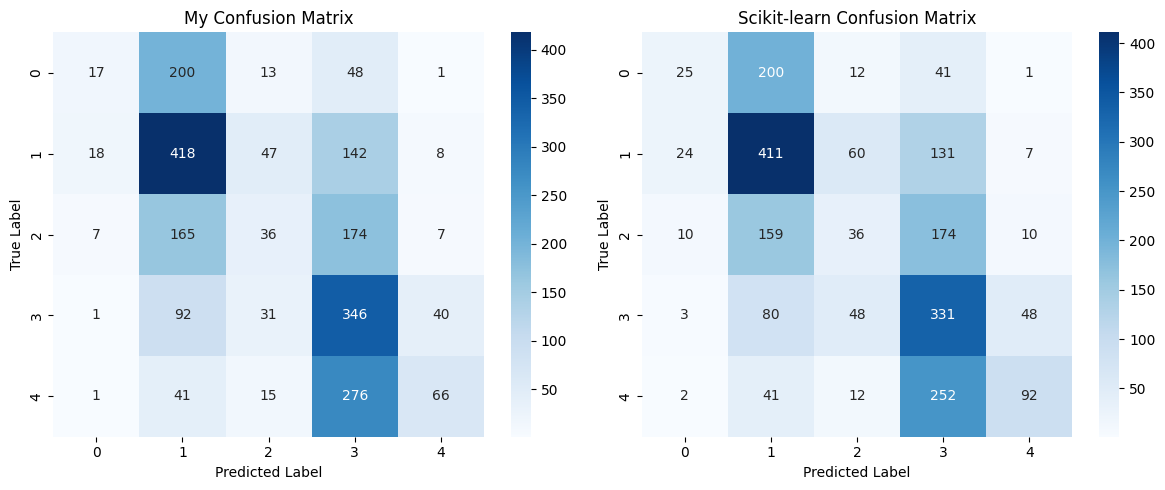

In [18]:
conf_matrix = generate_confusion_matrix(test_labels,y_pred)
conf_matrix_sklearn = confusion_matrix(test_labels,y_pred_sklearn)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot my confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("My Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot sklearn's confusion matrix
sns.heatmap(conf_matrix_sklearn, annot=True, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Scikit-learn Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Show the plots
plt.tight_layout()
plt.show()


##### Classification report

In [19]:
# My classification report
my_classification_report = generate_classification_report(test_labels,y_pred)
my_accuracy = np.sum(y_pred == test_labels)/len(test_labels)
macro_avg = my_classification_report.pop("macro_avg")
my_classification_report_df = pd.DataFrame(my_classification_report)
macro_avg = {
    'precision': macro_avg[0],
    'recall': macro_avg[1],
    'f1_score': macro_avg[2],
}
my_classification_report_df.loc['macro avg'] = macro_avg

# Sklearn classification report
classification_report_sklearn = classification_report(test_labels, y_pred_sklearn,output_dict=True)
accuracy_sklearn = classification_report_sklearn.pop("accuracy")
classification_report_sklearn_df = pd.DataFrame(classification_report_sklearn).T
classification_report_sklearn_df = classification_report_sklearn_df.drop(columns=['support'],index=['weighted avg'])

# Print both reports
print("My Classification Report:")
print(my_classification_report_df)
print(f"accuracy = {my_accuracy}")

print("\nScikit-learn Classification Report:")
print(classification_report_sklearn_df)
print(f"accuracy = {accuracy_sklearn}")

My Classification Report:
           precision    recall  f1_score
0           0.386364  0.060932  0.105263
1           0.456332  0.660348  0.539703
2           0.253521  0.092545  0.135593
3           0.350913  0.678431  0.462567
4           0.540984  0.165414  0.253359
macro avg   0.397623  0.331534  0.299297
accuracy = 0.3995475113122172

Scikit-learn Classification Report:
           precision    recall  f1-score
0           0.390625  0.089606  0.145773
1           0.461279  0.649289  0.539370
2           0.214286  0.092545  0.129264
3           0.356297  0.649020  0.460042
4           0.582278  0.230576  0.330341
macro avg   0.400953  0.342207  0.320958
accuracy = 0.40497737556561086


### Logistic Regression

#### Make predictions

In [20]:
# Initialize LogisticRegression
clf_logreg = LogisticRegression(max_iter=100, multi_class='multinomial', solver='lbfgs')
clf_logreg.fit(X_train, train_labels) 

# Initialize SGDClassifier as logistic regression
clf_sgd = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3, learning_rate='optimal', penalty='l2')
clf_sgd.fit(X_train, train_labels)

SGDClassifier(loss='log_loss', max_iter=100)

In [21]:
# Predict using LogisticRegression
y_pred_logreg = clf_logreg.predict(X_test)
# Predict using SGDClassifier
y_pred_sgd = clf_sgd.predict(X_test)

In [22]:
# Load the best model
data = np.load("best_model.npz")
W = data["W"]
B = data["B"]

# predictions using My model
y_pred = predict(X_test,W,B)

#### Confusion matrix

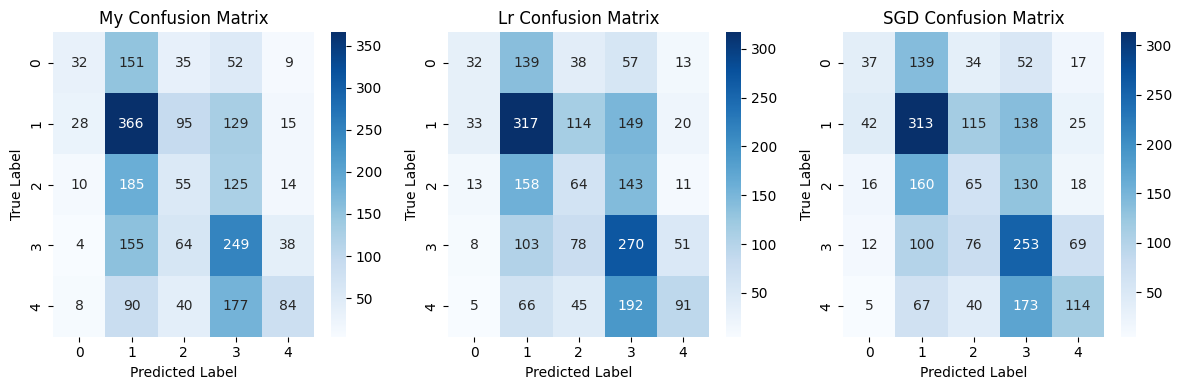

In [23]:
conf_matrix = generate_confusion_matrix(test_labels,y_pred)
conf_matrix_logreg = confusion_matrix(test_labels,y_pred_logreg)
conf_matrix_sgd = confusion_matrix(test_labels,y_pred_sgd)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot my confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("My Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot LogisticRegression confusion matrix
sns.heatmap(conf_matrix_logreg, annot=True, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Lr Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Plot SGDClassifier confusion matrix
sns.heatmap(conf_matrix_sgd, annot=True, fmt=".0f", cmap="Blues", ax=axes[2])
axes[2].set_title("SGD Confusion Matrix")
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")

# Show the plots
plt.tight_layout()
plt.show()

##### Classification report

In [24]:
# My classification report
my_classification_report = generate_classification_report(test_labels,y_pred)
my_accuracy = np.sum(y_pred == test_labels)/len(test_labels)
macro_avg = my_classification_report.pop("macro_avg")
my_classification_report_df = pd.DataFrame(my_classification_report)
macro_avg = {
    'precision': macro_avg[0],
    'recall': macro_avg[1],
    'f1_score': macro_avg[2],
}
my_classification_report_df.loc['macro avg'] = macro_avg

# LogisticRegression classification report
classification_report_logreg = classification_report(test_labels, y_pred_logreg,output_dict=True)
accuracy_logreg = classification_report_logreg.pop("accuracy")
classification_report_logreg_df = pd.DataFrame(classification_report_logreg).T
classification_report_logreg_df = classification_report_logreg_df.drop(columns=['support'],index=['weighted avg'])

# SGDClassifier classification report
classification_report_sgd = classification_report(test_labels, y_pred_sgd,output_dict=True)
accuracy_sgd = classification_report_sgd.pop("accuracy")
classification_report_sgd_df = pd.DataFrame(classification_report_sgd).T
classification_report_sgd_df = classification_report_sgd_df.drop(columns=['support'],index=['weighted avg'])

# Print the Reports
print("My Classification Report:")
print(my_classification_report_df)
print(f"accuracy = {my_accuracy}")

print("\nLogisticRegression Classification Report:")
print(classification_report_logreg_df)
print(f"accuracy = {accuracy_logreg}")

print("\nSGDClassifier Classification Report:")
print(classification_report_sgd_df)
print(f"accuracy = {accuracy_sgd}")

My Classification Report:
           precision    recall  f1_score
0           0.390244  0.114695  0.177285
1           0.386484  0.578199  0.463291
2           0.190311  0.141388  0.162242
3           0.340164  0.488235  0.400966
4           0.525000  0.210526  0.300537
macro avg   0.366441  0.306609  0.300864
accuracy = 0.3556561085972851

LogisticRegression Classification Report:
           precision    recall  f1-score
0           0.351648  0.114695  0.172973
1           0.404853  0.500790  0.447740
2           0.188791  0.164524  0.175824
3           0.332922  0.529412  0.408781
4           0.489247  0.228070  0.311111
macro avg   0.353492  0.307498  0.303286
accuracy = 0.3502262443438914

SGDClassifier Classification Report:
           precision    recall  f1-score
0           0.330357  0.132616  0.189258
1           0.401797  0.494471  0.443343
2           0.196970  0.167095  0.180807
3           0.339142  0.496078  0.402866
4           0.469136  0.285714  0.355140
macro avg   0